# Generation guide

1. **Pipeline from template** — use a ready text-to-image pipeline and run generation.
2. **Full graph with each node added separately** — build a graph from scratch by adding each node one by one (Conditioner, Denoise loop, Codec, then connect).

---
## 1. Pipeline from template

Get the pipeline from a text-to-image template and run generation. No graph building — just pipeline and generate.

Sampling: 100%|██████████| 30/30 [00:07<00:00,  3.83it/s]


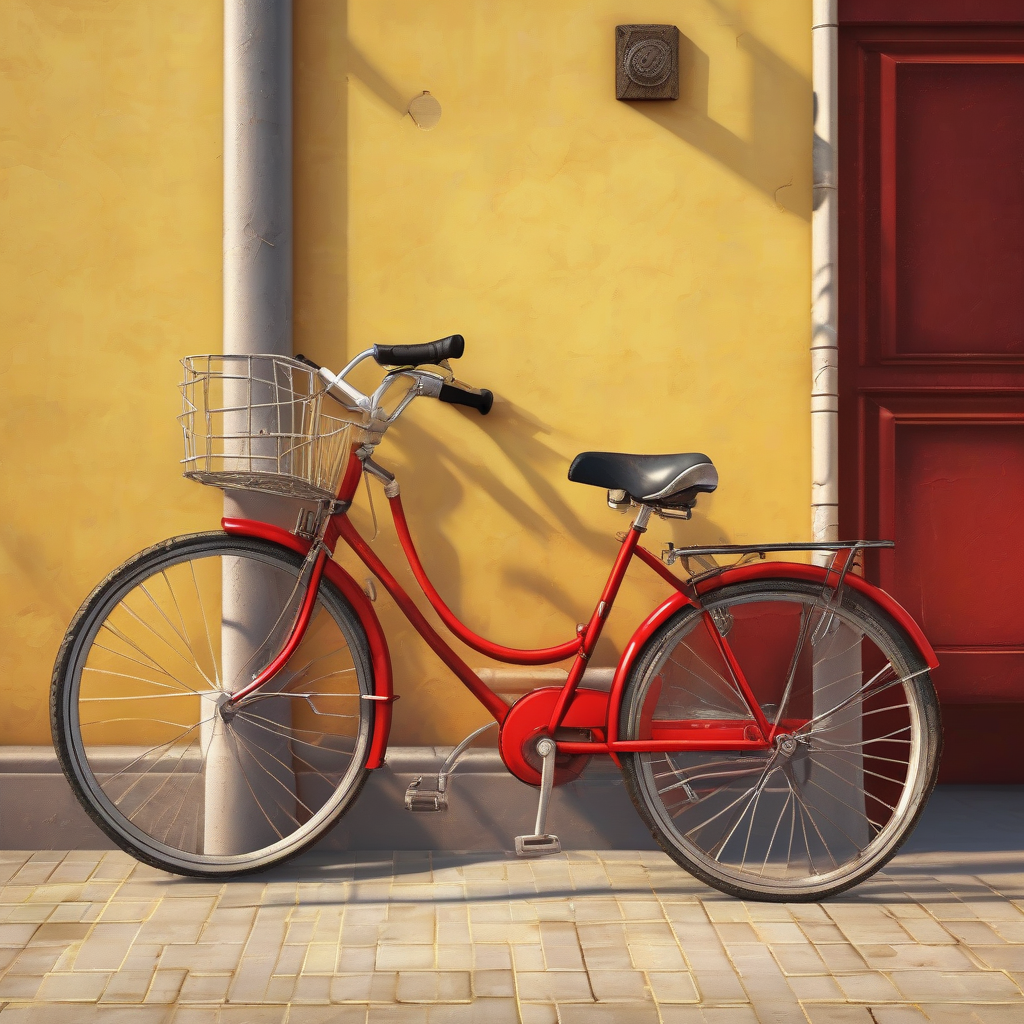

In [3]:
from pathlib import Path
from yggdrasil.pipeline import InferencePipeline

pipe = InferencePipeline.from_template(
    "sdxl_txt2img",
    device="cuda",
)

output = pipe(
    prompt="a red vintage bicycle leaning against a yellow wall, sunny day, photorealistic",
    num_steps=30,
    seed=42,
    guidance_scale=7.5,
    width=1024,
    height=1024,
)

img = output.images[0] if output.images else None
img

---
## 2. Full graph with each node added separately

Build a graph from scratch: create an empty graph, then **add each node one by one** — Conditioner, Denoise loop (with backbone, solver, etc. inside), Codec — then connect them and expose inputs/outputs.

### Step 1 — Empty graph and metadata

In [ ]:
from yggdrasil.core.graph.graph import ComputeGraph

pretrained = "stabilityai/stable-diffusion-xl-base-1.0"
device = "cuda"

graph = ComputeGraph(name="sdxl_full")
graph.metadata = {
    "default_guidance_scale": 7.5,
    "default_num_steps": 50,
    "default_width": 1024,
    "default_height": 1024,
    "latent_channels": 4,
    "spatial_scale_factor": 8,
    "modality": "image",
    "use_euler_init_sigma": True,
    "base_model": "sdxl",
}

print("Graph:", graph.name, "| nodes:", list(graph.nodes.keys()))

### Step 2 — Add node: Conditioner

In [ ]:
graph.add_node(
    "conditioner",
    type="conditioner/clip_sdxl",
    pretrained=pretrained,
    force_zeros_for_empty_prompt=True,
)

print("Nodes:", list(graph.nodes.keys()))

### Step 3 — Add node: Denoise loop (inner nodes: scale_input, backbone, solver)

In [ ]:
graph.add_node(
    "denoise_loop",
    type="loop/denoise_sdxl",
    pretrained=pretrained,
    num_steps=50,
    guidance_scale=7.5,
)

print("Nodes:", list(graph.nodes.keys()))

### Step 4 — Add node: Codec

In [ ]:
graph.add_node(
    "codec",
    type="codec/autoencoder_kl",
    pretrained=pretrained,
    fp16=True,
    scaling_factor=0.13025,
    latent_channels=4,
    spatial_scale_factor=8,
)

print("Nodes:", list(graph.nodes.keys()))

### Step 5 — Connect nodes and expose inputs/outputs

In [ ]:
graph.connect("conditioner", "condition", "denoise_loop", "condition")
graph.connect("conditioner", "uncond", "denoise_loop", "uncond")
graph.connect("denoise_loop", "latents", "codec", "latent")

graph.expose_input("prompt", "conditioner", "prompt")
graph.expose_input("negative_prompt", "conditioner", "negative_prompt")
graph.expose_input("height", "conditioner", "height")
graph.expose_input("width", "conditioner", "width")
graph.expose_input("latents", "denoise_loop", "initial_latents")
graph.expose_input("timesteps", "denoise_loop", "timesteps")

graph.expose_output("decoded", "codec", "decoded")
graph.expose_output("latents", "denoise_loop", "latents")

print("Inputs:", list(graph.graph_inputs.keys()))
print("Outputs:", list(graph.graph_outputs.keys()))

### Step 6 — Pipeline from graph and run generation

In [ ]:
from pathlib import Path
from yggdrasil.pipeline import InferencePipeline

graph.to(device)
pipe = InferencePipeline.from_graph(graph, device=device)

output = pipe(
    prompt="a red vintage bicycle, sunny day, photorealistic",
    num_steps=30,
    seed=42,
    guidance_scale=7.5,
    width=1024,
    height=1024,
)

img = output.images[0] if output.images else None
if img:
    Path("out").mkdir(exist_ok=True)
    out_path = Path("out") / "full_graph.png"
    img.save(out_path)
    print("Saved:", out_path)
img